# Results, section 2:

In [1]:
import os, sys
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ptitprince as pt

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/code/func/')
from proj_environment import set_proj_env
from func import run_corr, get_fdr_p, update_progress, get_null_p, get_cmap, get_fdr_p_df, get_sys_summary, prop_bar_plot, dependent_corr

In [3]:
train_test_str = 'squeakycleanExclude'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer'
parc_scale = 400 # 200 400 | 60 125
primary_covariate = 'ageAtScan1_Years'
extra_str = ''
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str,
                                                                            parc_str = parc_str, parc_scale = parc_scale, extra_str = extra_str)

In [4]:
sns.set(style='white', context = 'paper', font_scale = 1)

In [5]:
run_correlations = True
compute_perm_stats = False
num_perms = 1000

In [6]:
os.environ['NORMATIVEDIR']

'/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/analysis/normative/t1Exclude/squeakycleanExclude/schaefer_400/ageAtScan1_Years+sex_adj'

In [7]:
metrics = ('ct', 'vol')
phenos = ('Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear')

## Load data pre-nispat data

In [8]:
# Train
df_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'train.csv'))
df_train.set_index(['bblid', 'scanid'], inplace = True); print(df_train.shape)
df_node_train = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_train.csv'))
df_node_train.set_index(['bblid', 'scanid'], inplace = True)

# Test
df = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'test.csv'))
df.set_index(['bblid', 'scanid'], inplace = True); print(df.shape)
df_node = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'resp_test.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)

(410, 19)
(983, 19)


### Regress age/sex out of psychopathology phenotypes and node features (not deviations)

In [9]:
df_nuis = df.loc[:,[primary_covariate,'sex_adj']]
df_nuis = sm.add_constant(df_nuis)

# phenos
mdl = sm.OLS(df.loc[:,phenos], df_nuis).fit()
y_pred = mdl.predict(df_nuis)
y_pred.columns = phenos
df.loc[:,phenos] = df.loc[:,phenos] - y_pred

# df_node
cols = df_node.columns
mdl = sm.OLS(df_node.loc[:,cols], df_nuis).fit()
y_pred = mdl.predict(df_nuis)
y_pred.columns = cols
df_node.loc[:,cols] = df_node.loc[:,cols] - y_pred

/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [10]:
# phenos = ('Overall_Psychopathology','Psychosis_Positive')
# phenos = ('Psychosis_NegativeDisorg','AnxiousMisery')
# phenos = ('Externalizing','Fear')

## Age effects

In [11]:
# regress out sex
df_nuis = df_train.loc[:,'sex_adj']
df_nuis = sm.add_constant(df_nuis)

cols = df_node_train.columns
mdl = sm.OLS(df_node_train.loc[:,cols].astype(float), df_nuis.astype(float)).fit()
y_pred = mdl.predict(df_nuis)
y_pred.columns = cols
df_node_train.loc[:,cols] = df_node_train.loc[:,cols] - y_pred

In [12]:
# age effect on training set
df_age_effect = run_corr(df_train[primary_covariate], df_node_train, typ = 'spearmanr'); df_age_effect['p_fdr'] = get_fdr_p(df_age_effect['p'])
age_alpha = 0.05
age_filter = df_age_effect['p_fdr'].values < age_alpha

In [13]:
age_filter.sum()

618

## Load nispat outputs

In [14]:
smse = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'smse.txt'), delimiter = ' ').transpose()
df_smse = pd.DataFrame(data = smse, index = df_node.columns)

z = np.loadtxt(os.path.join(os.environ['NORMATIVEDIR'], 'Z.txt'), delimiter = ' ').transpose()
df_z = pd.DataFrame(data = z, index = df_node.index, columns = df_node.columns)

In [15]:
smse_thresh = 1
smse_filter = df_smse.values < smse_thresh
smse_filter = smse_filter.reshape(-1)

In [16]:
smse_filter.sum()

762

In [17]:
region_filter = np.logical_and(age_filter,smse_filter)
region_filter.sum()

607

### The interpretation of the z-deviations varies as a function of the age-effect from which the normative model is primarily derived.
### For instance, if the normative model predicts a _decrease_ in y with age, then _positive deviations_ may be interpreted as a **_delay_** in this maturational reduction, wheras _negative deviations_ may be interpreted as an _advancement_ in this maturational reduction.
### However, if the normative model predicts an _increase_ in y with age, then the interpretation of the deviations is reversed. That is:
#### IF predicted change = negative: _positive deviations_ = **_delay_** || _negative deviations_ = **_advance_**
#### IF predicted change = positive: _positive deviations_ = **_advance_** || _negative deviations_ = **_delay_**

In [18]:
# boolean that designates which regions carry with positive predicted change.
nm_is_pos = df_age_effect['coef'] > 0
print(nm_is_pos.sum())

# flipping the z-stats in these regions has the effect of standardising their interpration across the brain to be inline
# with the negative predicted change statement above
df_z.loc[:,nm_is_pos] = df_z.loc[:,nm_is_pos] * -1

77


## Get pheno-metric relationshisps

In [19]:
if run_correlations:
    df_pheno = pd.DataFrame(columns = ['pheno','node','coef', 'p'])
    df_corr_input = pd.concat((df.loc[:,phenos], df_node), axis = 1)

    for pheno in phenos:
        print(pheno)
        df_tmp = pd.DataFrame(index = df_node.columns, columns = ['coef', 'p'])
        for col in df_node.columns:
            df_tmp.loc[col,'coef'] = sp.stats.spearmanr(df_corr_input[pheno], df_corr_input[col])[0]
            df_tmp.loc[col,'p'] = sp.stats.spearmanr(df_corr_input[pheno], df_corr_input[col])[1]
        df_tmp.reset_index(inplace = True); df_tmp.rename(index=str, columns={'index': 'node'}, inplace = True); df_tmp['pheno'] = pheno
        df_pheno = df_pheno.append(df_tmp, sort = False)

    df_pheno.set_index(['pheno','node'], inplace = True)

Overall_Psychopathology
Psychosis_Positive
Psychosis_NegativeDisorg
AnxiousMisery
Externalizing
Fear


### Get null for pheno-metric

In [20]:
if compute_perm_stats:
    for pheno in phenos:
        # Set seed for reproducibility
        np.random.seed(0)
        null = np.zeros((df_node.shape[1],num_perms))
        df_tmp = pd.concat((df.loc[:,phenos], df_node), axis = 1)
                                      
        for j in range(num_perms):
            update_progress(j / num_perms, pheno)
            df_corr_input = df_tmp.copy()
            df_corr_input.loc[:,df_node.columns] = df_corr_input.loc[:,df_node.columns].sample(frac = 1).values
            for i, col in enumerate(df_node.columns):
                null[i,j] = sp.stats.spearmanr(df_corr_input[pheno], df_corr_input[col])[0]

        update_progress(1, pheno)
        np.save(os.path.join(os.environ['NORMATIVEDIR'], 'null_' + pheno + '_m'), null)

In [21]:
if compute_perm_stats == False:
    nulls = {'Overall_Psychopathology': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Overall_Psychopathology_m.npy')),
            'Psychosis_Positive': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Psychosis_Positive_m.npy')),
            'Psychosis_NegativeDisorg': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Psychosis_NegativeDisorg_m.npy')),
            'AnxiousMisery': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_AnxiousMisery_m.npy')),
            'Externalizing': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Externalizing_m.npy')),
            'Fear': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Fear_m.npy'))}

## Get pheno-nispat relationships

In [22]:
if run_correlations:
    df_pheno_z = pd.DataFrame(columns = ['pheno','node','coef', 'p'])
    df_corr_input = pd.concat((df.loc[:,phenos], df_z), axis = 1)

    for pheno in phenos:
        print(pheno)
        df_tmp = pd.DataFrame(index = df_z.columns, columns = ['coef', 'p'])
        for col in df_z.columns:
            df_tmp.loc[col,'coef'] = sp.stats.spearmanr(df_corr_input[pheno], df_corr_input[col])[0]
            df_tmp.loc[col,'p'] = sp.stats.spearmanr(df_corr_input[pheno], df_corr_input[col])[1]
        df_tmp.reset_index(inplace = True); df_tmp.rename(index=str, columns={'index': 'node'}, inplace = True); df_tmp['pheno'] = pheno
        df_pheno_z = df_pheno_z.append(df_tmp, sort = False)

    df_pheno_z.set_index(['pheno','node'], inplace = True)
    df_pheno_z = df_pheno_z.astype(float)

Overall_Psychopathology
Psychosis_Positive
Psychosis_NegativeDisorg
AnxiousMisery
Externalizing
Fear


### Get null for pheno-nispat 

In [23]:
if compute_perm_stats:
    for pheno in phenos:
        null = np.zeros((df_z.shape[1],num_perms))

        for j in range(num_perms):
            update_progress(j / num_perms, pheno)
            # load permuted z-stats
            permdir = os.path.join(os.environ['NORMATIVEDIR'], 'perm_all/perm_' + str(j))
            z_file = os.path.join(permdir, 'Z.txt')
            z_p = np.loadtxt(z_file, delimiter = ' ').transpose()
            z_p[:,nm_is_pos.values] = z_p[:,nm_is_pos.values] * -1
            z_p = pd.DataFrame(data = z_p, index = df_z.index, columns = df_z.columns)
            df_corr_input = pd.concat((df.loc[:,phenos], z_p), axis = 1)
            
            for i, col in enumerate(df_z.columns):
                null[i,j] = sp.stats.spearmanr(df_corr_input[pheno], df_corr_input[col])[0]
        update_progress(1, pheno)

        np.save(os.path.join(os.environ['NORMATIVEDIR'], 'null_' + pheno + '_z_pheno-res'), null)

In [24]:
if compute_perm_stats == False:
    nulls_z = {'Overall_Psychopathology': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Overall_Psychopathology_z_pheno-res.npy')),
        'Psychosis_Positive': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Psychosis_Positive_z_pheno-res.npy')),
        'Psychosis_NegativeDisorg': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Psychosis_NegativeDisorg_z_pheno-res.npy')),
        'AnxiousMisery': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_AnxiousMisery_z_pheno-res.npy')),
        'Externalizing': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Externalizing_z_pheno-res.npy')),
        'Fear': np.load(os.path.join(os.environ['NORMATIVEDIR'], 'null_Fear_z_pheno-res.npy'))}

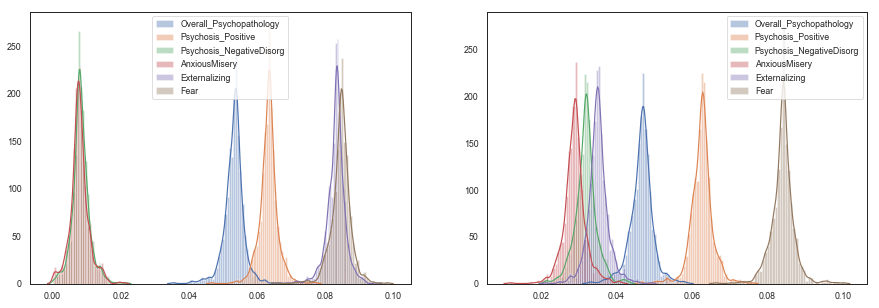

In [25]:
f, ax = plt.subplots(1,len(metrics))
f.set_figwidth(15)
f.set_figheight(5)
for i, metric in enumerate(metrics):
    for pheno in phenos:
#         null = nulls[pheno]
        null = nulls_z[pheno]
        idx = [any(b in s for b in metric) for s in list(df_z.columns)]
        null = null[idx,:]
        # collapse all regions
#         sns.distplot(np.abs(null.reshape(-1,1)[~np.isnan(null.reshape(-1,1))]), ax = ax[i])
        # pick a region
        sns.distplot(np.abs(null[0,:]), ax = ax[i])
    
    ax[i].legend(phenos)

In [26]:
if run_correlations == False:
    df_pheno = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'df_corr_pheno.csv'))
    df_pheno.set_index(['pheno','node'], inplace = True)
    
    df_pheno_z = pd.read_csv(os.path.join(os.environ['NORMATIVEDIR'], 'df_corr_pheno_z.csv'))
    df_pheno_z.set_index(['pheno','node'], inplace = True)

In [27]:
for pheno in phenos:
    df_pheno.loc[pheno,'p_perm'] = get_null_p(df_pheno.loc[pheno,'coef'].values, nulls[pheno])
df_pheno.loc[:,'p_perm_fdr'] = get_fdr_p(df_pheno.loc[:,'p_perm'])
print(str(np.sum(df_pheno['p_perm_fdr'] < .05)) + ' significant effects (fdr)')

40 significant effects (fdr)


In [28]:
for pheno in phenos:
    df_pheno_z.loc[pheno,'p_perm'] = get_null_p(df_pheno_z.loc[pheno,'coef'].values, nulls_z[pheno])    
df_pheno_z.loc[:,'p_perm_fdr'] = get_fdr_p(df_pheno_z.loc[:,'p_perm'])
print(str(np.sum(df_pheno_z['p_perm_fdr'] < .05)) + ' significant effects (fdr)')

594 significant effects (fdr)


/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/code/func/func.py:255: RuntimeWarning: invalid value encountered in greater_equal
  p_perm[i] = np.sum(r_perm >= r_obs) / num_perms


In [29]:
alpha = 0.05
print(len(phenos))
print(alpha)

6
0.05


In [30]:
x = df_pheno['p_perm_fdr'].values < alpha
df_pheno['sig'] = x

x = x.reshape(1,-1)
y = np.matlib.repmat(age_filter, 1, len(phenos))
z = np.matlib.repmat(smse_filter, 1, len(phenos))

my_bool = np.concatenate((x, y)); region_filter = np.all(my_bool, axis = 0); df_pheno['sig_age'] = region_filter
my_bool = np.concatenate((x, y, z)); region_filter = np.all(my_bool, axis = 0); df_pheno['sig_age_smse'] = region_filter

print(str(np.sum(df_pheno['sig'] == True)) + ' significant effects (fdr)')
print(str(np.sum(df_pheno['sig_age'] == True)) + ' significant effects (fdr)')
print(str(np.sum(df_pheno['sig_age_smse'] == True)) + ' significant effects (fdr)')

############
x = df_pheno_z['p_perm_fdr'].values < alpha
df_pheno_z['sig'] = x

x = x.reshape(1,-1)
y = np.matlib.repmat(age_filter, 1, len(phenos))
z = np.matlib.repmat(smse_filter, 1, len(phenos))

my_bool = np.concatenate((x, y)); region_filter = np.all(my_bool, axis = 0); df_pheno_z['sig_age'] = region_filter
my_bool = np.concatenate((x, y, z)); region_filter = np.all(my_bool, axis = 0); df_pheno_z['sig_age_smse'] = region_filter

print(str(np.sum(df_pheno_z['sig'] == True)) + ' significant effects (fdr)')
print(str(np.sum(df_pheno_z['sig_age'] == True)) + ' significant effects (fdr)')
print(str(np.sum(df_pheno_z['sig_age_smse'] == True)) + ' significant effects (fdr)')

40 significant effects (fdr)
29 significant effects (fdr)
29 significant effects (fdr)
594 significant effects (fdr)
482 significant effects (fdr)
478 significant effects (fdr)


In [31]:
for pheno in phenos:
    print(pheno + ': ' + str(np.sum(df_pheno.loc[pheno]['sig_age_smse'] == True)) + ' significant effects (fdr)')

Overall_Psychopathology: 6 significant effects (fdr)
Psychosis_Positive: 9 significant effects (fdr)
Psychosis_NegativeDisorg: 0 significant effects (fdr)
AnxiousMisery: 0 significant effects (fdr)
Externalizing: 2 significant effects (fdr)
Fear: 12 significant effects (fdr)


In [32]:
for pheno in phenos:
    print(pheno + ': ' + str(np.sum(df_pheno_z.loc[pheno]['sig_age_smse'] == True)) + ' significant effects (fdr)')

Overall_Psychopathology: 65 significant effects (fdr)
Psychosis_Positive: 148 significant effects (fdr)
Psychosis_NegativeDisorg: 97 significant effects (fdr)
AnxiousMisery: 45 significant effects (fdr)
Externalizing: 65 significant effects (fdr)
Fear: 58 significant effects (fdr)


In [33]:
df_pheno.to_csv(os.path.join(os.environ['NORMATIVEDIR'], 'df_corr_pheno.csv'))
df_pheno_z.to_csv(os.path.join(os.environ['NORMATIVEDIR'], 'df_corr_pheno_z.csv'))

# Plots

In [34]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = get_cmap('pair')

phenos = ('Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear')
phenos_label_short = ('Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear')
phenos_label = ('Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear')
metrics = ('ct', 'vol')
metrics_label_short = ('Thickness', 'Volume')
metrics_label = ('Thickness', 'Volume')

print(phenos)
print(metrics)

metrics_labels = list()
for metric in metrics:
    tmp_labels = [metric + '_' + str(i) for i in range(num_parcels)]
    metrics_labels = metrics_labels + tmp_labels

('Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg', 'AnxiousMisery', 'Externalizing', 'Fear')
('ct', 'vol')


## Number of sig effects

In [35]:
arrays = [tuple(['pre-nm'] * len(metrics) + ['nm'] * len(metrics)), metrics + metrics]
my_index = pd.MultiIndex.from_arrays(arrays, names=('analysis', 'metric'))
pos_counts = pd.DataFrame(index = my_index, columns = phenos)
neg_counts = pd.DataFrame(index = my_index, columns = phenos)

In [36]:
for pheno in phenos:
    for metric in metrics:
        age_filt = df_age_effect.filter(regex = metric, axis = 0)['p_fdr'].values < age_alpha
        smse_filt = df_smse.filter(regex = metric, axis = 0).values < smse_thresh
        smse_filt = smse_filt.reshape(-1)
        region_filt = np.logical_and(age_filt,smse_filt)
        
        df_tmp = df_pheno.loc[pheno,['coef','sig_age_smse']].filter(regex = metric, axis = 0).copy()
        pos_counts.loc[('pre-nm',metric),pheno] = df_tmp.loc[df_tmp['coef']>0,'sig_age_smse'].sum() / num_parcels*100
        neg_counts.loc[('pre-nm',metric),pheno] = df_tmp.loc[df_tmp['coef']<0,'sig_age_smse'].sum() / num_parcels*100
        
        df_tmp = df_pheno_z.loc[pheno,['coef','sig_age_smse']].filter(regex = metric, axis = 0).copy()
        pos_counts.loc[('nm',metric),pheno] = df_tmp.loc[df_tmp['coef']>0,'sig_age_smse'].sum() / num_parcels*100
        neg_counts.loc[('nm',metric),pheno] = df_tmp.loc[df_tmp['coef']<0,'sig_age_smse'].sum() / num_parcels*100

In [37]:
pos_counts

Overall_Psychopathology Psychosis_Positive  \
analysis metric                                              
pre-nm   ct                           0                  0   
         vol                          0                  0   
nm       ct                        6.25                  1   
         vol                       0.75               0.75   

                Psychosis_NegativeDisorg AnxiousMisery Externalizing  Fear  
analysis metric                                                             
pre-nm   ct                            0             0             0     0  
         vol                           0             0             0     0  
nm       ct                            0           2.5             1  1.25  
         vol                        0.25             4          0.25  1.75

In [38]:
if np.max(pos_counts.values) > np.max(neg_counts.values):
    plot_max = np.round(np.max(pos_counts.values),0)
elif np.max(pos_counts.values) < np.max(neg_counts.values):
    plot_max = np.round(np.max(neg_counts.values),0)
elif np.max(pos_counts.values) == np.max(neg_counts.values):
    plot_max = np.round(np.max(pos_counts.values),0)
print(plot_max)

20.0


Figure 3A

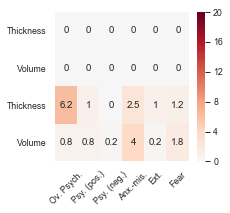

In [39]:
f, ax = plt.subplots()
f.set_figwidth(3)
f.set_figheight(2.75)
ax = sns.heatmap(np.round(pos_counts.astype(float),1), center = 0, vmax = plot_max, annot = True, cmap = 'RdBu_r')
ax.set_xticklabels(phenos_label_short, rotation = 45)
ax.set_yticklabels(metrics_label_short + metrics_label_short)
ax.set_ylabel('')
f.savefig('pos_count.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

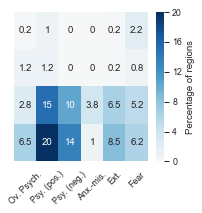

In [40]:
f, ax = plt.subplots()
f.set_figwidth(3)
f.set_figheight(2.75)
ax = sns.heatmap(np.round(neg_counts.astype(float),1), center = 0, vmax = plot_max, annot = True, cmap = 'RdBu', cbar_kws={'label': 'Percentage of regions'})
ax.set_xticklabels(phenos_label_short, rotation = 45)
ax.set_yticklabels('')
ax.set_ylabel('')
f.savefig('neg_count.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

In [41]:
num_sig_regions = pd.DataFrame(index = metrics, columns = phenos)
counts_greater = pd.DataFrame(index = metrics, columns = phenos)
counts_smaller = pd.DataFrame(index = metrics, columns = phenos)

for i, metric in enumerate(metrics):
    for j, pheno in enumerate(phenos):
        df_tmp = df_pheno.loc[pheno,['coef','sig_age_smse']].filter(regex = metric, axis = 0).copy()
        df_tmp_z = df_pheno_z.loc[pheno,['coef','sig_age_smse']].filter(regex = metric, axis = 0).copy()
        
        count_great = 0
        count_small = 0
        for col, _ in df_tmp_z.loc[df_tmp_z['sig_age_smse'],:].iterrows():
#         for col, _ in df_tmp.loc[df_tmp['sig_age_smse'],:].iterrows():
            xy = np.abs(df_tmp_z.loc[col,'coef']) # correlation between phenotype and deviation
            xz = np.abs(df_tmp.loc[col,'coef']) # correlation between phenotype and brain feature
            yz = np.abs(sp.stats.spearmanr(df_node[col],df_z[col])[0]) # correlation deviation and brain feature
            r = dependent_corr(xy, xz, yz, df_z.shape[0], twotailed=True) # test for difference between correlations
            if r[0] > 0 and r[1] < .05: # if difference is positive and significant, then normative analysis yielded bigger effect size
                count_great += 1
            elif r[0] < 0 and r[1] < .05: # if difference is negative and significant, then normative analysis yielded smaller effect size
                count_small += 1
        # store
        counts_greater.loc[metric,pheno] = count_great
        counts_smaller.loc[metric,pheno] = count_small

In [42]:
counts_greater

,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg,AnxiousMisery,Externalizing,Fear
ct,6,13,0,3,2,6
vol,10,36,0,2,0,16


In [43]:
counts_smaller

,Overall_Psychopathology,Psychosis_Positive,Psychosis_NegativeDisorg,AnxiousMisery,Externalizing,Fear
ct,0,1,0,0,0,0
vol,0,0,0,0,0,0


## Summarise effects over Yeo networks

In [44]:
sns.set(style='white', context = 'paper', font_scale = 0.7)

Figure 4

/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


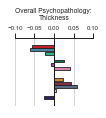

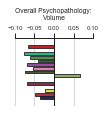

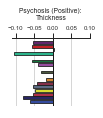

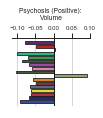

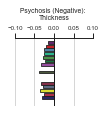

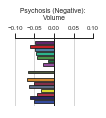

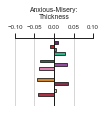

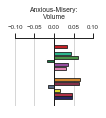

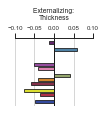

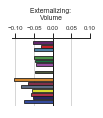

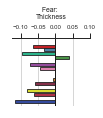

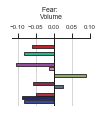

In [45]:
for i, pheno in enumerate(phenos):
    pheno_label = phenos_label[i]
    for j, metric in enumerate(metrics):
        metric_label = metrics_label[j]

        # Get coefficients and p-vals for phenotype effects
        coef = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['coef'].values
        p_vals = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['p_perm_fdr'].values # only plot significant coefficients
        sig = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['sig_age_smse'].values
        p_vals[~sig] = 1
    
        # Summarise phenotype effects over systems
        # present mean effect in system
        sys_summary = get_sys_summary(coef, p_vals, yeo_idx, method = 'mean', alpha = alpha, signed = False)
        f, ax = prop_bar_plot(sys_summary, np.ones(sys_summary.shape), labels = '', which_colors = 'yeo17', axlim = 0.1, title_str = pheno_label + ': \n' + metric_label, fig_size = [1.4,1.25])
        f.savefig('corr_bar_' + pheno + '_' + metric + '_z.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Brain plots nispat

In [46]:
import matplotlib.image as mpimg
from brain_plot_func import roi_to_vtx, brain_plot

In [47]:
subject_id = 'fsaverage'

In [48]:
%pylab qt

Populating the interactive namespace from numpy and matplotlib


/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['get_cmap', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Brain plots nispat

In [49]:
for pheno in phenos:
    for metric in metrics:
        for hemi in ('lh', 'rh'):
            print(pheno, metric)
            # Plots of univariate pheno correlation
            fig_str = hemi + '_' + pheno + '_' + metric + '_z'
            roi_data = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['coef'].values
            sig = df_pheno_z.loc[pheno].filter(regex = metric, axis = 0)['sig_age_smse']

            roi_data[~sig] = -1000

            if any(sig):
                parc_file = os.path.join('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec/figs_support/Parcellations/FreeSurfer5.3/fsaverage/label/',
                                             hemi + '.Schaefer2018_' + str(parc_scale) + 'Parcels_17Networks_order.annot')
                # project subject's data to vertices
                brain_plot(roi_data, parcel_names, parc_file, fig_str, subject_id = subject_id, hemi = hemi)
            else:
                print('Nothing significant')

Overall_Psychopathology ct
0.07999227642865983
colormap divergent: center=0.00e+00, [0.00e+00, 4.00e-02, 8.00e-02] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 4.00e-02, 8.00e-02] (opaque)
Overall_Psychopathology ct
0.0891836876394509
colormap divergent: center=0.00e+00, [0.00e+00, 4.46e-02, 8.92e-02] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 4.46e-02, 8.92e-02] (opaque)
Overall_Psychopathology vol
0.08419630925633169
colormap divergent: center=0.00e+00, [0.00e+00, 4.21e-02, 8.42e-02] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 4.21e-02, 8.42e-02] (opaque)
Overall_Psychopathology vol
0.09363594098796557
colormap divergent: center=0.00e+00, [0.00e+00, 4.68e-02, 9.36e-02] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 4.68e-02, 9.36e-02] (opaque)
Psychosis_Positive ct
0.07673851228673956
colormap divergent: center=0.00e+00, [0.00e+00, 3.84e-02, 7.67e-02] (opaque)
colormap divergent: center=0.00e+00, [0.00e+00, 3.84e-02, 7.67e-02] (opaque)

In [50]:
%matplotlib inline

Figure 4A

Overall_Psychopathology
ct


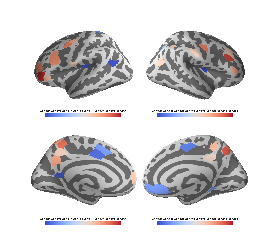

In [51]:
f, axes = plt.subplots(2, 2)
f.set_figwidth(4)
f.set_figheight(4)
plt.subplots_adjust(wspace=0, hspace=0)

pheno = phenos[0]; print(pheno)
metric = metrics[0]; print(metric)
# column 0:
fig_str = 'lh_'+pheno+'_'+metric+'_z.png'
try:
#     axes[0,0].set_title('Thickness (left)')
    image = mpimg.imread('lat_' + fig_str); axes[0,0].imshow(image); axes[0,0].axis('off')
except FileNotFoundError: axes[0,0].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,0].imshow(image); axes[1,0].axis('off')
except FileNotFoundError: axes[1,0].axis('off')
    
# column 1:
fig_str = 'rh_'+pheno+'_'+metric+'_z.png'
try:
#     axes[0,1].set_title('Thickness (right)')
    image = mpimg.imread('lat_' + fig_str); axes[0,1].imshow(image); axes[0,1].axis('off')
except FileNotFoundError: axes[0,1].axis('off')
try:
    image = mpimg.imread('med_' + fig_str); axes[1,1].imshow(image); axes[1,1].axis('off')
except FileNotFoundError: axes[1,1].axis('off')

plt.show()
f.savefig(metric+'_'+pheno+'_z.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0)